In [1]:
import pandas as pd
import xgboost as xgb
import operator
from matplotlib import pylab as plt
from sklearn import preprocessing
%matplotlib inline

C:\Users\uaadmin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#read data from cvs files 
path_to_Base1 = './Base1.csv'
path_to_Base2 = './Base2.csv' 
path_to_test = './test.csv'
path_to_train = './train.csv'

Base1_df = pd.read_csv(path_to_Base1, sep=',')
Base2_df = pd.read_csv(path_to_Base2, sep=',')
train_df = pd.read_csv(path_to_train, sep=',')
test_df = pd.read_csv(path_to_test, sep=',')

In [3]:
# #select  data only for the last month (MONTH_AGO =6) 
Base2M1=Base2_df.loc[Base2_df['MONTH_AGO'] == 6] 

In [4]:
#prepare train and test datasets 
train=pd.merge(train_df, Base2M1, on='ID', how='left')
train=pd.merge(train, Base1_df, on='ID', how='left')
test=pd.merge(test_df, Base2M1, on='ID', how='left')
test=pd.merge(test, Base1_df, on='ID', how='left')

In [5]:
print (train.shape,test.shape)

(10000, 49) (5000, 49)


In [6]:
train.head(5)

,Target,ID,MONTH_AGO,V1,V2,V3,V4,V5,V6,V7,...,V37,V38,V39,V40,V41,T1,T2,T3,T4,T5
0,1,6851,6,29.433679,0.0,22.982971,0.000000,0.000000,109.348176,298.570739,...,0.000000,0.0,235.676187,35.412292,24.024417,0.0,93683a6e0b6bd3edd67ef43c2cecb4cfbd6b06d27722d9...,8ea76c2c46d5517b905cf8e07813b1110d61c9ed452431...,0fb19dacd118115dfae8dac219437a8527f4f28bce7074...,7ea85151d13febdc421dd3ebacba8d9c08c3688f3a9c29...
1,3,1485,6,17.169646,0.0,20.684674,0.000000,5.347143,85.686942,184.233201,...,0.881786,0.0,97.043136,31.871063,32.633166,NaN,NaN,NaN,NaN,NaN
2,3,2587,6,0.000000,0.0,20.684674,1.243865,NaN,22.497432,364.187396,...,0.000000,0.0,356.980106,31.871063,15.832091,1.0,06f2421bcda7cedcdc3478204645904af812e62238f165...,e7843ac01206c17efd45575f6e9f9443a138a099a4ac35...,ba52f8d4b29586449c5cd6ef81890cb9af48f492ba99c5...,973ca067b185cbd2ae7ef795d3e35e98454309e3c3d083...
3,2,7834,6,93.206649,0.0,21.450773,0.000000,1.782381,32.635620,207.712669,...,0.758336,NaN,84.335106,31.871063,13.862088,0.0,2904ac38d4fedd52ccb2c11cb3038a68004844fbdcb832...,8ea76c2c46d5517b905cf8e07813b1110d61c9ed452431...,f4447ab9a18e074f7d0aa56c6417296976ac0a168275d3...,7ea85151d13febdc421dd3ebacba8d9c08c3688f3a9c29...
4,1,9337,6,22.565820,0.0,NaN,0.000000,1.782381,124.190744,461.566229,...,0.529071,0.0,381.240890,35.412292,35.395974,1.0,e24e85d37fb651d26714fe75c55af377484ba67b651141...,1133a816b2e3f67edd21524d05e3f4da41c9fc9ae00df4...,ba52f8d4b29586449c5cd6ef81890cb9af48f492ba99c5...,973ca067b185cbd2ae7ef795d3e35e98454309e3c3d083...


In [7]:
test.head(5)

,Target,ID,MONTH_AGO,V1,V2,V3,V4,V5,V6,V7,...,V37,V38,V39,V40,V41,T1,T2,T3,T4,T5
0,0,13921,6,51.018376,0.845,NaN,34.828215,0.000000,44.093328,142.135340,...,0.000000,0.0,185.999343,34.231882,26.827265,1.0,5dbcd4d33ba732c89e2810565fdcd0202629a046e6a370...,b55a5ab83b4d4958e1772a7b582bca034043c893dbb77b...,ba52f8d4b29586449c5cd6ef81890cb9af48f492ba99c5...,973ca067b185cbd2ae7ef795d3e35e98454309e3c3d083...
1,0,11966,6,27.961995,0.000,22.982971,0.000000,0.891191,113.044476,462.329214,...,9.505648,0.0,226.433983,35.412292,29.141618,0.0,ab24f5d32981ecc35c76070c7347d0711b0bc4e27e3187...,1133a816b2e3f67edd21524d05e3f4da41c9fc9ae00df4...,0fb19dacd118115dfae8dac219437a8527f4f28bce7074...,7ea85151d13febdc421dd3ebacba8d9c08c3688f3a9c29...
2,0,11025,6,0.000000,0.000,15.321981,0.000000,0.000000,15.547406,80.333604,...,0.000000,0.0,71.627076,23.608195,12.364566,0.0,e63bbbeab8931f671216801eb10bf95176e98595bf3e74...,e7843ac01206c17efd45575f6e9f9443a138a099a4ac35...,ba52f8d4b29586449c5cd6ef81890cb9af48f492ba99c5...,973ca067b185cbd2ae7ef795d3e35e98454309e3c3d083...
3,0,13484,6,39.244905,0.000,22.216872,0.000000,0.000000,30.529303,133.113246,...,0.000000,0.0,97.043136,34.231882,17.417702,0.0,a7d89f618b81d0d6fd8ac715febd482456516a73b29a56...,8ea76c2c46d5517b905cf8e07813b1110d61c9ed452431...,0fb19dacd118115dfae8dac219437a8527f4f28bce7074...,7ea85151d13febdc421dd3ebacba8d9c08c3688f3a9c29...
4,0,14333,6,158.451303,0.845,22.982971,34.828215,6.238334,62.779720,253.751305,...,2.645357,0.0,231.055085,35.412292,53.254124,0.0,8a7a3c721cb971c8ff22eaf366714e7fd344ad979d93c6...,618fe54518955213355d132a95d89bb2e4e2ac5b3e554e...,ba52f8d4b29586449c5cd6ef81890cb9af48f492ba99c5...,973ca067b185cbd2ae7ef795d3e35e98454309e3c3d083...


In [8]:
#Data preprocessing
labels = train.Target.values
labels = preprocessing.LabelEncoder().fit_transform(labels)
train = train.drop(["ID", "Target"], axis=1)
features=list(train.columns[0:])
test = test.drop(["ID", "Target"], axis=1)

In [9]:
#Divide categorical and numerical features:
features = [x for x in train.columns if x not in ['ID','Target']]

cat_features = [x for x in train.select_dtypes(
        include=['object']).columns if x not in ['ID','Target']]
num_features = [x for x in train.select_dtypes(
        exclude=['object']).columns if x not in ['ID','Target']]

print ("Categorical features:" , len(cat_features))
print ("Numerical features:", len(num_features))

Categorical features: 4
Numerical features: 43


In [10]:
# use a label encoder for categorical features
## for train dataset  
train= train[features]
for c in range(len(cat_features)):
    train[cat_features[c]] = train[cat_features[c]].astype('category').cat.codes
## for test dataset    
test= test[features]
for c in range(len(cat_features)):
    test[cat_features[c]] = test[cat_features[c]].astype('category').cat.codes
# convert variable to a float
train[['T2', 'T3', 'T4', 'T5']] = train[['T2', 'T3', 'T4', 'T5']].astype(float)
test[['T2', 'T3', 'T4', 'T5']] = test[['T2', 'T3', 'T4', 'T5']].astype(float)

In [11]:
# Simple XGBoost Model

#to do multiclass classification use the softmax objective and set number of classes = 3 

params = {"objective": "multi:softmax", "num_class": 3}

#transform datasets into the DMatrix
train_xgb = xgb.DMatrix(train, labels)
test_xgb  = xgb.DMatrix(test)
trainRound = 33

In [12]:
gbm = xgb.train(params, train_xgb, trainRound)
pred = gbm.predict(test_xgb)

In [13]:
# create a feature map
outfile = open('xgb.fmap', 'w')
i = 0
for feat in features:
    outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    i = i + 1
outfile.close()

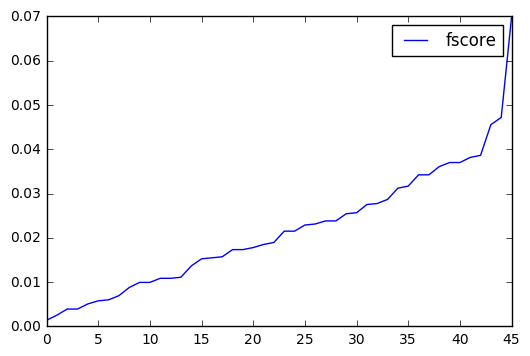

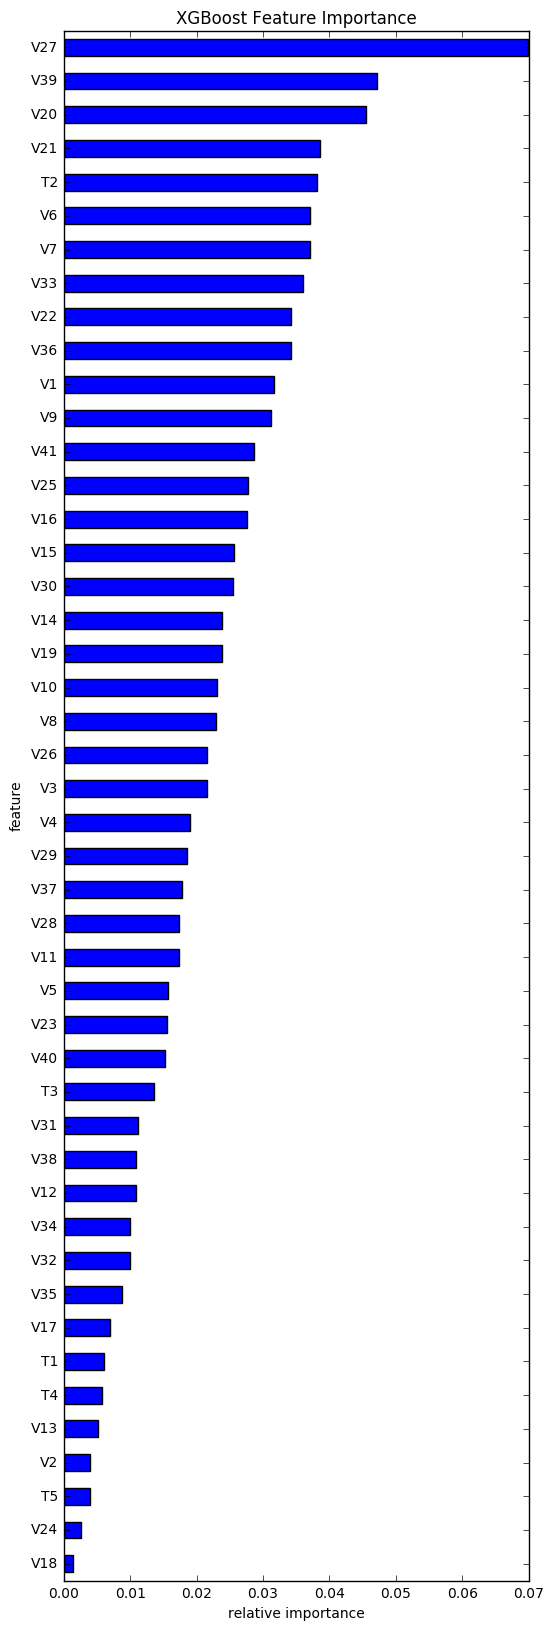

In [14]:
# plot feature importance
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 20))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

In [15]:
pred1 = pd.DataFrame(pred)
test_df['Target']=pred1+1
test_df[['Target','ID']]= test_df[['Target','ID']].astype(int)

In [16]:
# create submission file
test_df.to_csv('test.csv',mode = 'w', index=False )